<a href="https://colab.research.google.com/github/akimotolab/CMAES_Tutorial/blob/main/0_black_box_optimization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ブラックボックス最適化とは

ブラックボックス最適化 (Black-Box Optimization, BBO) とは，入力 (i.e., 解，設計変数) $x$ の良さを表す指標 (i.e., 目的関数値，コスト) $f(x)$ がブラックボックスであるような場合に，$f(x)$を最適化する$x$を求める問題を表します．

ここでは，ブラックボックス最適化を実際に解いてみることで，ブラックボックス最適化というものを理解していきましょう．

## 自分でBBO問題を解いてみる

まずは自分の手でBBO問題を解いてみましょう．
以下のコードを見ないで実行し，すぐに非表示にしましょう．

### 問題定義　（実行後非表示）

In [7]:
import numpy as np
import matplotlib.pyplot as plt

class BBO:
    def __init__(self):
        self._hist = np.empty((0, 3))
    def __call__(self, x, y):
        gx = self.g(x, y)
        fx = self.f(x, y)
        if gx > 0:
            return np.inf
        else:
            self._hist = np.vstack((self._hist, np.array([x, y, fx])))
            return fx
    def plot(self):
        fig = plt.figure()
        plt.scatter(x=self._hist[:, 0], y=self._hist[:, 1], c=self._hist[:, 2], cmap='Blues', edgecolors='blue')
        plt.colorbar()
        fig.gca().set_aspect('equal')
        plt.ylim((0, 1))
        plt.xlim((0, 1))
        plt.xlabel('x')
        plt.ylabel('y')
    def g(self, x, y):
        return max(np.abs(x - 0.5) - 0.5, np.abs(y - 0.5) - 0.5)
    def f(self, x, y):
        a = 2.0
        scale = 3.0
        offset_x = 0.2
        offset_y = - 0.1
        xx = 10 * (x - offset_x) - 5
        yy = 10 * (y - offset_y) - 5
        xxx = (xx + np.sqrt(3) * yy) / 2
        yyy = scale * (np.sqrt(3) * xx - yy) / 2
        return np.sqrt(xxx**2 + a * (1.0 - np.cos(2 * np.pi * xxx)) + yyy**2 + a * (1.0 - np.cos(2 * np.pi * yyy)))
    def contourf(self):
        delta = 0.01
        x = y = np.arange(0.0, 1.0, delta)
        X, Y = np.meshgrid(x, y)
        Z = self.f(X, Y)
        fig = plt.figure()
        plt.contourf(X, Y, Z, 100, cmap='rainbow')
        plt.colorbar()
        fig.gca().set_aspect('equal')
        plt.ylim((0, 1))
        plt.xlim((0, 1))
        plt.xlabel('x')
        plt.ylabel('y')
    def get_hist(self):
        return np.array(self._hist, copy=True)

### 実行スクリプト
ここで考える問題は2変数の最適化問題です．

`bbo(x, y)`：$f(x, y)$の評価．
各変数は$[0, 1]$の範囲の値を取ります．
それ以外の値を入力した場合，実行不能と判断され，目的関数値は$\infty$となります．

`bbo.plot()`：これまでに評価した実行可能解の散布図を表示します．

`bbo.get_hist()`：これまでに評価した実行可能解の2D配列を返します．各行が[$x$, $y$, $f(x, y)$]


In [8]:
bbo = BBO()

以下の$x, y$を変えながら，最適解を予想していきましょう．
まず，定義域の中心を評価してみます．

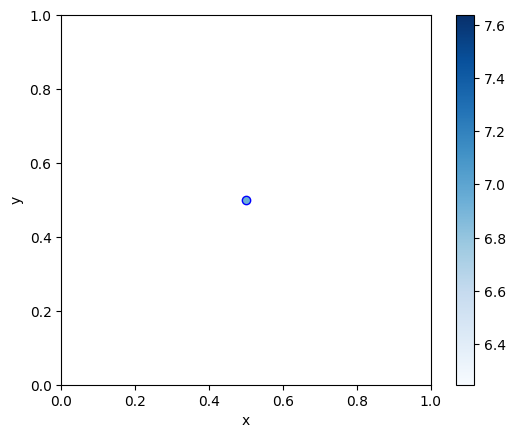

In [9]:
bbo(0.5, 0.5)
bbo.plot()

境界付近のいくつかの点を評価してみます．

[[ 0.5         0.5         6.94175606]
 [ 0.1         0.1        12.57877191]
 [ 0.1         0.9        23.19724205]
 [ 0.9         0.1        10.14224714]
 [ 0.9         0.9         6.27269528]]


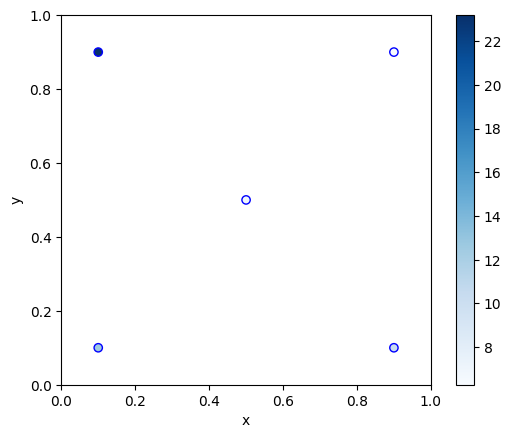

In [10]:
bbo(0.1, 0.1)
bbo(0.1, 0.9)
bbo(0.9, 0.1)
bbo(0.9, 0.9)
bbo.plot()
print(bbo.get_hist())

あとは自分で予想して，評価をくりかえして行きましょう．
x と y を変えて，繰り返し評価して見てください．

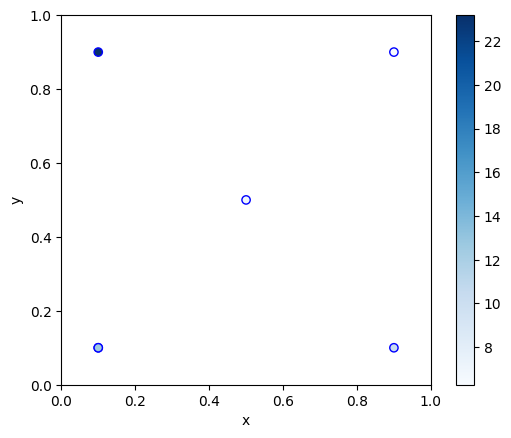

In [11]:
bbo(0.1, 0.1)
bbo.plot()

さて，この問題の最適解は$(0.7, 0.4)$であり，$f(0.7, 0.4) = 0$でした．
等高線は以下のようになります．

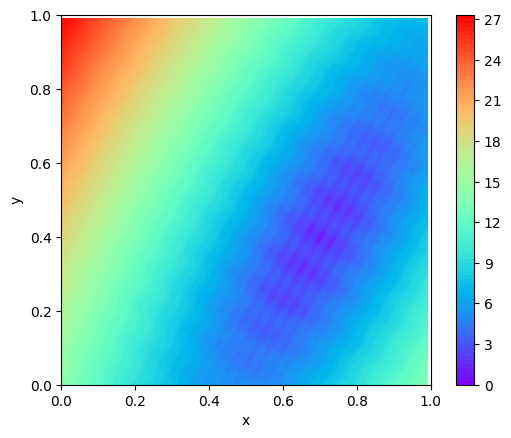

In [12]:
bbo.contourf()

BBOでは，良い解を探索する手がかりが，これまでに評価した解とその目的関数の組$\{(x, f(x))\}$のみとなります．
これらの情報を効率よく活用していくことが重要です．

## 網羅的に探索してみる

このような問題を解く一つのアプローチとして，網羅的に目的関数値を評価してみる，という方針が思い浮かぶでしょう．
これを実際にやってみましょう．

ここでは，各次元について，$[0, 1]$を境界を含んで$K$個の点で分割し，合計$K^2$個のグリッド上の格子点について，解を評価してみます．

In [13]:
bbo = BBO()
K = 20
x_array = np.linspace(0, 1, num=K)
y_array = np.linspace(0, 1, num=K)
for x in x_array:
    for y in y_array:
        bbo(x, y)

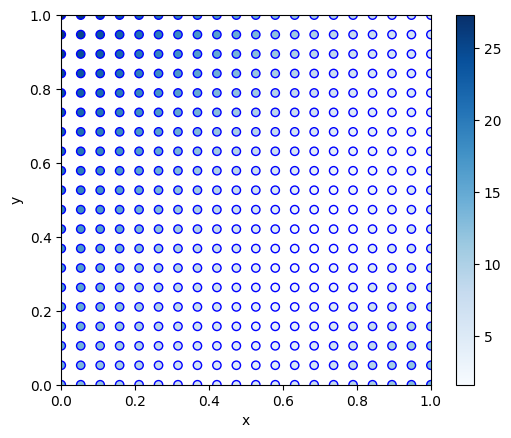

In [14]:
bbo.plot()

In [15]:
min(bbo.get_hist()[:, 2])

1.6202216653950825

偶然最適解が格子点上にならない限り，この方法では最適解を当てることはできませんが，概ね良い解が得られることはわかるかと思います．

ただし，この方法が現実的なのは極低次元の場合に限られます．
次元数を$d$としたとき，$K^d$個の解を評価することが必要になるためです．
一般に，目的関数値を評価するためには，数値シミュレーションを実行するなどのコストがかかるため，膨大な回数の評価は現実的でない場合が多くあります．

また，過去に評価した解の情報を活用していないことにも気がつくと思います．
荒いグリッド上の点を評価し，そこから次に探索領域を絞り込み，その付近で同じことを実施する，ということを繰り返す方が，有望でなさそうな領域（例えば左上の領域など）を評価することにコストを費やさずに済むため，効率が良さそうであることがわかるかと思います．

## (1+1)-ES with 1/5 success rule による最適化

ここで，伝統的な進化戦略の一つである，(1+1)-ESを見てみましょう．
(1+1)-ESは非常に単純ですが，強力なアプローチであり，強凸かつ勾配がリプシッツ連続になるような目的関数や，その単調増加関数を含む問題クラスにおいて，一次収束（解が最適解に向かって指数的に収束していく）することが理論的に示されています．

(1+1)-ESは，正規分布$\mathcal{N}(x, \sigma^2)$による新しい解の生成を繰り返します．ただし，新しい解を生成し，評価するたびに，その情報を用いて正規分布の平均ベクトル$x$と標準偏差$\sigma$を更新し，良い解を生成しやすくするようにしています．

以下，(1+1)-ESを定義しています．非常に単純である（実質10行以下）ことがわかるかと思います．
`ask`は新しい解を正規分布から生成し，返します．
`tell`は評価された解の情報を用いて，分布パラメータを更新します．

In [42]:
class ES:
    def __init__(self, init_s, init_x, init_fx):
        self.fx = init_fx
        self.x = np.array(init_x, copy=True)
        self.s = init_s
        self.dim = len(self.x)
        self.alpha = np.exp(1.0 / self.dim)
        self.y = np.empty(self.dim)

    def ask(self):
        self.y = self.x + self.s * np.random.randn(self.dim)
        return self.y

    def tell(self, fx):
        if self.fx < fx:
            self.s /= self.alpha**(0.25)
        else:
            self.s *= self.alpha
            self.x = self.y
            self.fx = fx

それでは実際に実行してみましょう．
正規分布の初期値を与える必要があります．ここでは，定義域の中心に平均ベクトルを初期化し，標準偏差を定義域の幅の半分としています．

In [43]:
bbo = BBO()
s = 0.5
x = np.ones(2) * 0.5
fx = bbo(x[0], x[1])
es = ES(s, x, fx)

以下，メインループです．
解をT回評価するまで，探索を繰り返します．

In [44]:
T = 100
while len(bbo.get_hist()) < T:
    x = es.ask()
    fx = bbo(x[0], x[1])
    es.tell(fx)

0.993283398320405


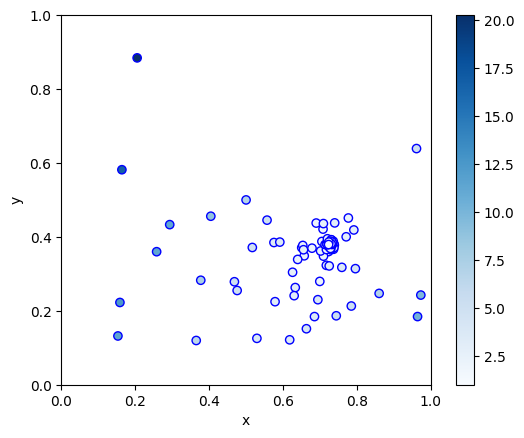

In [45]:
bbo.plot()
print(min(bbo.get_hist()[:, 2]))

この問題は局所解が多数存在する問題になっています．
そのため，(1+1)-ESは必ずしも大域的最適解には収束しませんが，局所解に収束していく様子が見て取れます．
また，確率的な探索を行うため，実行のたびに異なる局所解に収束することも確認できます．
生成された解の目的関数値の履歴を見ると，収束していく様子が見て取れます．

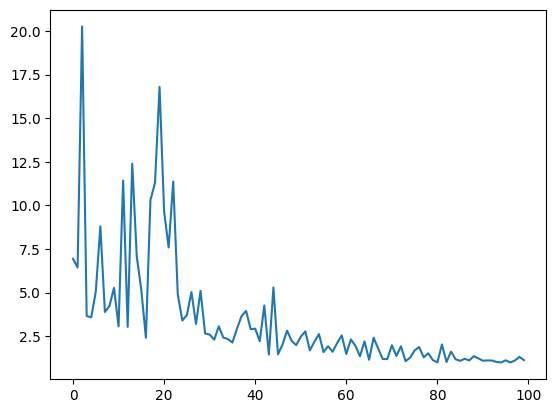

In [47]:
import matplotlib.pyplot as plt
plt.plot(bbo.get_hist()[:, 2])